# Raga Predictor Model

### Libraries used:
1. Pretty MIDI - For Handling MIDI Files
2. numpy and pandas - For Data Handling

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import os
import math
import pretty_midi
from sklearn.ensemble import RandomForestClassifier
from hmmlearn import hmm
from sklearn.metrics import accuracy_score, classification_report

### Feature Extraction

In [2]:
hindustani_notes = ["S", "r", "R", "g", "G", "m", "M", "P", "d", "D", "n", "N"]

def get_pitch_class_and_octave(midi_notes , base_note):
    notes_with_octave = []

    for note , _ , _ in midi_notes:
        pitch_class = (note-base_note)%12
        note_name = hindustani_notes[pitch_class]
        octave = note // 12 - 1
        notes_with_octave.append(f"{note_name}{octave}")
    
    return notes_with_octave


In [3]:
def calculate_pitch_class_distribution(midi_notes, base_note):
    # Calculate total duration for each pitch class relative to the base note as Sa
    pitch_class_durations = Counter()
    
    for note, duration , _ in midi_notes:
        relative_pitch = (note - base_note) % 12
        pitch_class_durations[relative_pitch] += duration
    
    # Normalize durations to get the distribution
    total_duration = sum(pitch_class_durations.values())
    pitch_class_dist = {
        hindustani_notes[pitch_class]: duration / total_duration
        for pitch_class, duration in pitch_class_durations.items()
    }
    
    return pitch_class_dist

In [4]:
# Returns np array with its columns as pitch , duration , velocity
def extract_midi_data(midi_path , base_note):
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    note_features = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            # Extract pitch, note duration and velocity
            note_features.append([note.pitch , note.end - note.start , note.velocity])
    
    # Extract pitch class with octave using the base note
    notes_with_octave = get_pitch_class_and_octave(note_features , base_note=base_note)
    pitch_class_dist = calculate_pitch_class_distribution(note_features , base_note)

    df = pd.DataFrame(note_features , columns=['pitch' , 'duration' , 'velocity'])
    df['notes_with_octave'] = notes_with_octave
    return df , pitch_class_dist

In [5]:
# Function to iterate through all MIDI files in a folder and store the extracted data
def extract_midi_data_from_folder(folder_path , base_note):
    midi_data_collection = [] # Stores data for all MIDI files

    # Itereate through the folder
    for filename in os.listdir(folder_path):
        if not (filename.endswith(".mid") or not filename.endswith(".midi")):
            continue

        midi_file_path = os.path.join(folder_path , filename)

        #  Extract data from current MIDI file
        midi_features , pitch_class_dist = extract_midi_data(midi_file_path , base_note)

        # Store the extracted data along with filename
        midi_data_collection.append({
            'filename': filename ,
            'data': midi_features ,
            'pitch_class_distribution': pitch_class_dist
        })
    
    return midi_data_collection

Visualize Pitch Class Distribution

In [6]:
def visualize_pcd(pitch_class_dist):
    # Define the swara order
    hindustani_notes = ["S", "r", "R", "g", "G", "m", "M", "P", "d", "D", "n", "N"]
    
    # Sort pitch_class_dist based on Hindustani swara order
    sorted_notes = sorted(pitch_class_dist.keys(), key=lambda x: hindustani_notes.index(x))
    sorted_values = [pitch_class_dist[note] for note in sorted_notes]
    
    # Create bar chart
    plt.figure(figsize=(5, 3))
    plt.bar(sorted_notes, sorted_values, color='skyblue')
    plt.xlabel("Pitch Class (Hindustani Notation)")
    plt.ylabel("Normalized Frequency")
    plt.title("Pitch Class Distribution")
    
    # Add value labels above bars
    for i, value in enumerate(sorted_values):
        plt.text(i, value + 0.01, f"{value:.2f}", ha='center')
    
    plt.show()

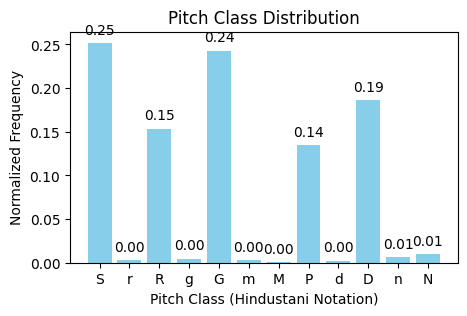

In [7]:
# midi_data = pretty_midi.PrettyMIDI("Final-Bhupali-HC-Flute-MIDI.mid")
df , pitch_class_dist = extract_midi_data(midi_path="Final-Bhupali-AP-Flute.mid" , base_note=64)
visualize_pcd(pitch_class_dist)

Labels

In [8]:
def raag_labels(midi_data_collection):
    features = []
    labels = []

    for item in midi_data_collection:
        # Label for raga 
        raga_label = item['filename'].split('_')[0]
        labels.append(raga_label)

    
    return np.array(labels)        

In [9]:
midi_data_collection = extract_midi_data_from_folder("Raga Segments" , base_note=64)
midi_data_collection

[{'filename': 'AhirBhairav_HC_E_1.mid',
  'data':     pitch  duration  velocity notes_with_octave
  0      59  0.088636        75                P3
  1      64  3.545455        89                S4
  2      64  0.620455        38                S4
  3      63  0.220455        67                N4
  4      64  0.597727        69                S4
  5      64  3.011364        84                S4
  6      64  0.734091        42                S4
  7      64  0.602273        98                S4
  8      61  2.293182       104                D4
  9      62  0.156818        88                n4
  10     61  0.961364       103                D4
  11     61  0.170455        78                D4
  12     61  0.375000        44                D4
  13     59  2.188636        78                P3
  14     64  0.763636       106                S4
  15     62  1.775000        97                n4
  16     59  0.079545        49                P3
  17     61  0.068182        43                D4
  

In [10]:
labels = raag_labels(midi_data_collection)
labels

array(['AhirBhairav', 'AhirBhairav', 'AhirBhairav', 'AhirBhairav',
       'AhirBhairav', 'AhirBhairav', 'AhirBhairav', 'AhirBhairav',
       'AhirBhairav', 'AhirBhairav', 'AhirBhairav', 'AhirBhairav',
       'AhirBhairav', 'AhirBhairav', 'AhirBhairav', 'AhirBhairav',
       'AhirBhairav', 'AhirBhairav', 'Bhupali', 'Bhupali', 'Bhupali',
       'Bhupali', 'Bhupali', 'Bhupali', 'Bhupali', 'Bhupali', 'Bhupali',
       'Bhupali', 'Bhupali', 'Bhupali', 'Bhupali', 'Bhupali', 'Bhupali',
       'Bhupali', 'Bhupali', 'Bhupali', 'Bhupali', 'BrindawaniSarang',
       'BrindawaniSarang', 'BrindawaniSarang', 'BrindawaniSarang',
       'BrindawaniSarang', 'BrindawaniSarang', 'BrindawaniSarang',
       'BrindawaniSarang', 'BrindawaniSarang', 'BrindawaniSarang',
       'BrindawaniSarang', 'BrindawaniSarang', 'BrindawaniSarang',
       'BrindawaniSarang', 'BrindawaniSarang', 'BrindawaniSarang',
       'BrindawaniSarang', 'BrindawaniSarang', 'GujriTodi', 'GujriTodi',
       'GujriTodi', 'GujriTodi', 'Guj

Prepare Data

In [11]:
ragas = np.unique(labels)
models = {}
ragas

array(['AhirBhairav', 'Bhupali', 'BrindawaniSarang', 'GujriTodi'],
      dtype='<U16')

### Model Training

In [12]:
for raga in ragas:
    raga_data = [item['data'][['pitch' , 'duration' , 'velocity']].values for item , label in zip(midi_data_collection , labels) if label == raga]

    # Fit HMM for each raga using its data
    lengths = [len(seq) for seq in raga_data]
    raga_data_concat = np.concatenate(raga_data)

    model = hmm.GaussianHMM(n_components=3 , covariance_type='diag' , n_iter=50)
    model.fit(raga_data_concat , lengths)
    models[raga] = model

print("Trained HMM models for each raga.")
raga_data_concat

Trained HMM models for each raga.


array([[ 63.        ,   4.475     ,  93.        ],
       [ 63.        ,   4.30909091, 104.        ],
       [ 60.        ,   0.22272727,  85.        ],
       ...,
       [ 60.        ,   0.25454545,  85.        ],
       [ 63.        ,   0.65681818,  92.        ],
       [ 64.        ,   1.48636364,  85.        ]])

In [13]:
models

{'AhirBhairav': GaussianHMM(n_components=3, n_iter=50),
 'Bhupali': GaussianHMM(n_components=3, n_iter=50),
 'BrindawaniSarang': GaussianHMM(n_components=3, n_iter=50),
 'GujriTodi': GaussianHMM(n_components=3, n_iter=50)}

In [14]:
def predict_raga_hmm(midi_sample):
    scores = {raga: model.score(midi_sample[['pitch', 'duration', 'velocity']].values) for raga, model in models.items()}
    return max(scores, key=scores.get)

## Testing Model

Example prediction HMM using a sample from the training data

In [21]:
test_sample = midi_data_collection[26]['data']
predicted_raga = predict_raga_hmm(test_sample)
print(f"Predicted raga: {predicted_raga}")

Predicted raga: Bhupali


In [22]:
# Extracting data from Test Files Folder
test_midi_collection = extract_midi_data_from_folder("Testing Files" , base_note=64)
test_midi_collection

[{'filename': 'AhirBhairav_HC_E_12.mid',
  'data':     pitch  duration  velocity notes_with_octave
  0      64  0.209091        38                S4
  1      64  0.204545        28                S4
  2      64  0.459091        41                S4
  3      64  0.231818        36                S4
  4      64  1.884091       106                S4
  ..    ...       ...       ...               ...
  84     64  0.156818        48                S4
  85     64  0.611364       109                S4
  86     64  0.172727        68                S4
  87     62  0.702273       103                n4
  88     64  0.327273       112                S4
  
  [89 rows x 4 columns],
  'pitch_class_distribution': {'S': 0.4555603263203093,
   'n': 0.14579457086971057,
   'D': 0.19250035780735647,
   'r': 0.17298792996517331,
   'P': 0.0331568150374504}},
 {'filename': 'AhirBhairav_HC_E_9.mid',
  'data':      pitch  duration  velocity notes_with_octave
  0       76  0.552273       109                S5


In [24]:
# Example prediction HMM using a sample from testing data
test_sample = test_midi_collection[6]['data']  # Replace with an actual test sample
predicted_raga = predict_raga_hmm(test_sample)
print(f"Predicted raga: {predicted_raga}")

Predicted raga: GujriTodi


#### Calculating Model Accuracy

In [25]:
test_labels = raag_labels(test_midi_collection)

# Initialize counters for accuracy
correct_predictions = 0
total_predictions = len(test_midi_collection)

# Loop through each test sample
for i, test_sample in enumerate(test_midi_collection):
    sample_data = test_sample['data']

    predicted_raga = predict_raga_hmm(sample_data)
    actual_raga = test_labels[i]
    
    if predicted_raga == actual_raga:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions
print(f"HMM accuracy: {accuracy * 100:.2f}%")


HMM accuracy: 100.00%
